### BayFlux Demo Notebook: Infer fluxes from Fig. 3 of Antoniewicz 2007
By Tyler W. H. Backman

This notebook demonstrates Bayesian MCMC sampling from the simple test model in Fig. 3 of Antoniewicz 2007 (see citation below). We intend this notebook to serve as a template for use in more complicated projects.

In this notebook we import data from the following four files, created in an accompanying notebook:
* **File 1:** Metabolic model (.sbml format)
* **File 2:** Extracellular exchange and flux bounds (.csv format)
* **File 3:** Atom transitions for each reaction (.txt format)
* **File 4:** Mass distribution experimental data (.tab format)

Citation:

Antoniewicz MR, Kelleher JK, Stephanopoulos G. Elementary metabolite units (EMU): a novel framework for modeling isotopic distributions. Metab Eng. 2007;9(1):68-86. doi:10.1016/j.ymben.2006.09.001

#### Load Python libraries

In [1]:
%matplotlib inline

In [2]:
import os
import cobra
from cobra.sampling import MCMCACHRSampler
import bayflux
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
print(cobra.__version__)
print(bayflux.__version__)

0.18.1
1.0


#### Filenames for data import

In [3]:
# Data directory
dataDir = 'input_data'

# File 1: Metabolic model (.sbml format)
modelFile = os.path.join(dataDir, 'fig3toyModel.xml')

# File 2: Extracellular exchange and flux bounds (.csv format)
fluxBoundsFile = os.path.join(dataDir, 'fig3toyFluxBounds.csv')

# File 3: Atom transitions for each reaction (.txt format)
transitionsFile = os.path.join(dataDir, 'fig3toyTransitions.txt')

# File 4: Mass distribution experimental data (.tab format)
mdvFile = os.path.join(dataDir, 'fig3toyMassDistribution.tab')

#### Import model and set flux bounds

In [4]:
# Read the model file
cobrapymodel = cobra.io.read_sbml_model(modelFile)
model = bayflux.ReactionNetwork(cobrapymodel)
model

Name,fig3
Memory address,0x04077e5f510
Number of metabolites,6
Number of reactions,8
Number of groups,0
Objective expression,1.0*d_f - 1.0*d_f_reverse_5ee53
Compartments,c


Import and apply exchange fluxes from file

In [5]:
model.readFluxConstraints(fluxBoundsFile)

Set some flux bounds to limit the search space of the model. For test purposes we have narrow bounds here
so the notebook runs quickly, for real world models much larger bounds may be necessary and reasonable.

In [6]:
# set maximum flux to 1.5x the input flux, to limit the search space
carbonInputReaction = model.reactions.get_by_id('a_exchange')
limit = 1.5 * -carbonInputReaction.lower_bound
for reaction in model.reactions:
    if reaction.lower_bound < -limit:
        reaction.lower_bound = -limit
    if reaction.upper_bound > limit:
        reaction.upper_bound = limit

Run FBA (Flux Balance Analysis) to confirm that the model is valid and can carry flux

In [7]:
model.optimize()

,fluxes,reduced_costs
a_b,100.0,0.0
b_ec,0.0,0.0
bc_de,0.0,-2.0
d_f,100.0,0.0
b_d,100.0,0.0
a_exchange,-100.0,-2.0
e_exchange,0.0,0.0
f_exchange,100.0,0.0


#### Read atom transitions and apply to model

In [8]:
model.readAtomTransitions(transitionsFile)

#### Read mass distribution data

In [9]:
importedMDVs = bayflux.readMassDistribution(model, mdvFile)
importedMDVs

  metabolite  atoms       0       1       2       3
0          F  0,1,2  0.0001  0.8008  0.1983  0.0009

#### Specify the number of extra neutrons in each position of the carbon inputs

In [10]:
substrateLabelingDict = {
    model.metabolites.get_by_id('A'): ((1.0, [0, 1, 0]),),
}

#### Pre-compile EMU network

In [11]:
compiledData = bayflux.emuCompile(list(importedMDVs.data.keys()), model, substrateLabelingDict)

#### Placeholder: These functions will be moved into the main package before final release

In [12]:
def normpdf(x, mean, sd):
    # based on this but with np.log added https://codereview.stackexchange.com/a/98891
    # much faster, bur same answer as norm.logpdf
    var = float(sd)**2
    denom = (2*np.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return np.log(num/denom)

def logLikelihood(fluxVector, lcmsResults=importedMDVs, compiledData=compiledData, substrateLabelingDict=substrateLabelingDict, errorSD=0.010):

    # simulate labeling distribution
    try:
        results = bayflux.simulateLabeling(compiledData, fluxVector, substrateLabelingDict)
    except np.linalg.LinAlgError:
        print('LinAlgError')
        return np.finfo(np.float32).min # return a really low probability if we get an error
    
    logLikelihood = 0
    
    # find overlap between results and predicted EMUs
    for emu, mdvs in lcmsResults.data.items():
        emuHash = hash(emu)
        found = False
        for singleSize in compiledData:
            if emuHash in singleSize['matrixCoords']['internalEMUs']['hashes']:
                index = singleSize['matrixCoords']['internalEMUs']['hashes'].index(emuHash)
                found = True
                # zip together experimental results and simulated results into pairwise
                # tuples
                for mdv in mdvs:
                    for comparison in zip(mdv, results[singleSize['size']][index]):
                        logLikelihood += normpdf(comparison[0], comparison[1], errorSD)
        assert found == True, 'missing MDV in simulated results for ' + repr(emu)
    return logLikelihood

In [13]:
def pairPlot(samples, reactions, thinning=1):
    # plot sample distribution for warmup samples
    g = sns.PairGrid(samples[reactions].iloc[::thinning, :], diag_sharey=False) # plot only every 10th sample
    # g = sns.PairGrid(samples[reactions], diag_sharey=False)
    g.map_lower(plt.hexbin, gridsize=25, cmap=plt.get_cmap('Blues'), linewidths=0)
    g.map_diag(sns.kdeplot, lw=3, gridsize=100)
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)

#### Initialize sampler and collect uniform samples to identify the center of the metabolic model

In [14]:
# initialize the sampler
mcmcachr = cobra.sampling.MCMCACHRSampler(model, thinning=1, seed=43)

In [15]:
# collect uniform samples in order to identify the center of the model
centeringSamples = mcmcachr.sample(100000, fluxes=False, validatecheck=True)

searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output= ['e']
searching new valid sample as validate output=

<AxesSubplot:>

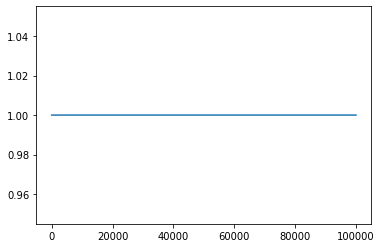

In [16]:
# show sample validation (1.0 = valid)
tol = 1e-6
pd.Series([int(x) for x in (mcmcachr.validate(centeringSamples, feas_tol=tol, bounds_tol=tol) == 'v')]).plot()

In [17]:
# create a list of the reactions we want to plot fluxes for
reactionsToPlot = ['b_ec', 'd_f', 'b_d', model.reactions.get_by_id('b_d').reverse_variable.name]

<AxesSubplot:>

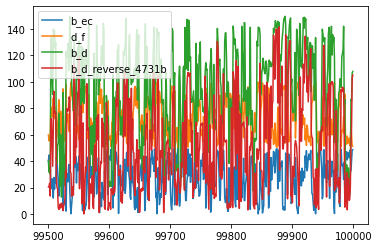

In [18]:
# inspect mixing in the last  warmup samples
centeringSamples[reactionsToPlot][-500:].plot()

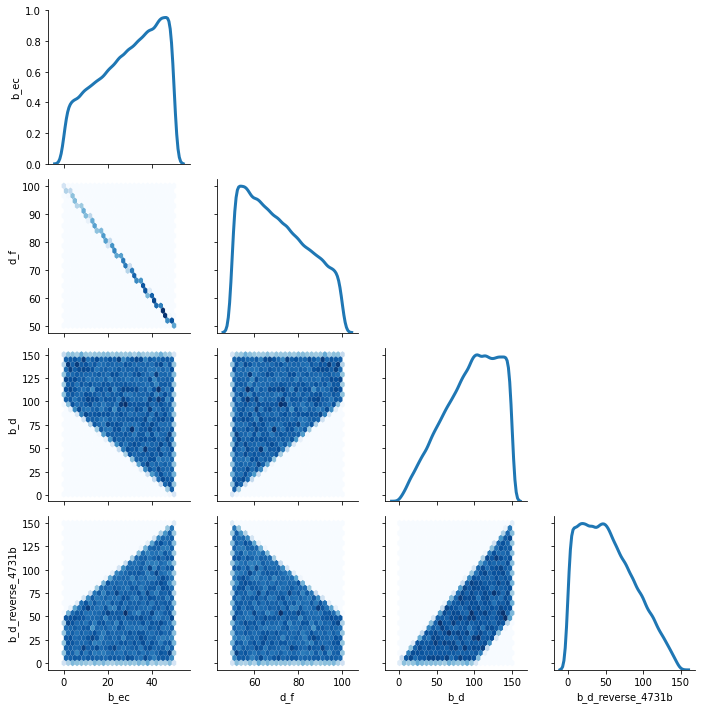

In [19]:
pairPlot(centeringSamples, reactionsToPlot)

#### Infer 13C MFA Posterior distribution from 13C Data using MCMC

In [20]:
posteriorSamples = mcmcachr.sample(100000, fluxes=False, likelihood=logLikelihood, validatecheck=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7 RuntimeWarning: divide by zero encountered in log


acceptance rate: 0.07274


In [21]:
posteriorSamples

,a_b,a_b_reverse_dbf08,b_ec,b_ec_reverse_e30a6,bc_de,bc_de_reverse_eb6e8,d_f,d_f_reverse_5ee53,b_d,b_d_reverse_4731b,a_exchange,a_exchange_reverse_75264,e_exchange,e_exchange_reverse_35070,f_exchange,f_exchange_reverse_1b286
0,100.0,0.0,15.169035,0.0,15.169035,0.0,84.830965,0.0,112.818665,43.156735,0.0,100.0,45.507107,0.0,84.830965,0.0
1,100.0,0.0,15.169035,0.0,15.169035,0.0,84.830965,0.0,112.818665,43.156735,0.0,100.0,45.507107,0.0,84.830965,0.0
2,100.0,0.0,15.169035,0.0,15.169035,0.0,84.830965,0.0,112.818665,43.156735,0.0,100.0,45.507107,0.0,84.830965,0.0
3,100.0,0.0,22.113143,0.0,22.113143,0.0,77.886857,0.0,130.865826,75.092112,0.0,100.0,66.339430,0.0,77.886857,0.0
4,100.0,0.0,22.113143,0.0,22.113143,0.0,77.886857,0.0,130.865826,75.092112,0.0,100.0,66.339430,0.0,77.886857,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,100.0,0.0,19.108546,0.0,19.108546,0.0,80.891454,0.0,102.827231,41.044323,0.0,100.0,57.325638,0.0,80.891454,0.0
99996,100.0,0.0,19.108546,0.0,19.108546,0.0,80.891454,0.0,102.827231,41.044323,0.0,100.0,57.325638,0.0,80.891454,0.0
99997,100.0,0.0,19.108546,0.0,19.108546,0.0,80.891454,0.0,102.827231,41.044323,0.0,100.0,57.325638,0.0,80.891454,0.0
99998,100.0,0.0,19.108546,0.0,19.108546,0.0,80.891454,0.0,102.827231,41.044323,0.0,100.0,57.325638,0.0,80.891454,0.0


In [22]:
# show frequency of validtions
# from cobrapy code:
#            - 'v' means feasible in bounds and equality constraints
#            - 'l' means a lower bound violation
#            - 'u' means a lower bound validation
#            - 'e' means and equality constraint violation
            
validationResult = pd.Series(mcmcachr.validate(centeringSamples))
validationResult.value_counts()

v    100000
dtype: int64

<AxesSubplot:>

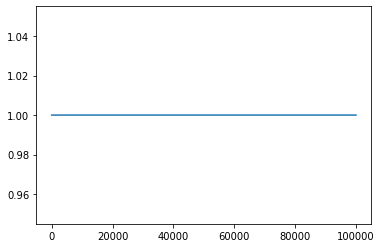

In [23]:
# show sample validation (1.0 = valid)
tol = 1e-6
pd.Series([int(x) for x in (mcmcachr.validate(posteriorSamples, feas_tol=tol, bounds_tol=tol) == 'v')]).plot()

<AxesSubplot:>

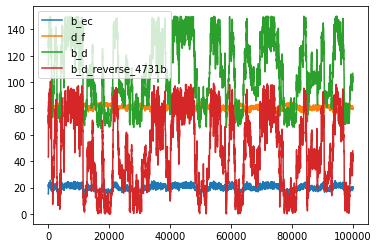

In [24]:
# realSamples[allRxns].plot()
posteriorSamples[reactionsToPlot].plot()

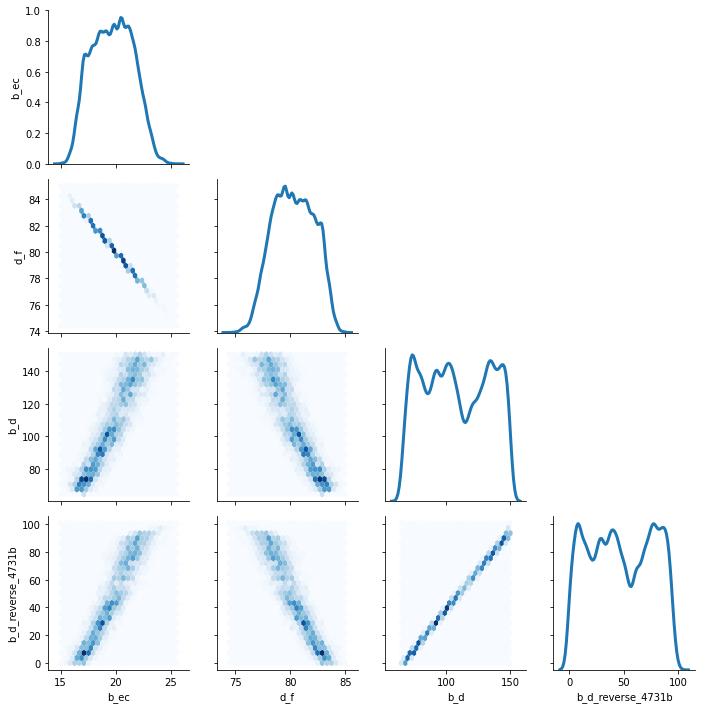

In [25]:
pairPlot(posteriorSamples, reactionsToPlot)

#### Compare best sample predicted labeling to published metabolite F MDV of [0.0001, 0.8008, 0.1983, 0.0009] and fluxes of {'a_b': [100, 0], 'b_d': [110, 50], 'b_ec': [20, 0], 'bc_de': [20, 0], 'd_f': [80, 0]}

In [26]:
# Inspect the likeihood of the best sample collected
display(mcmcachr.bestSample[0])

14.744877406817778

In [27]:
# Inspect the flux distributions of the best sample collected
pd.DataFrame(mcmcachr.bestSample[1], index=[v.name for v in model.variables], columns=['Flux'])

,Flux
a_b,100.000000
a_b_reverse_dbf08,0.000000
b_ec,19.984490
b_ec_reverse_e30a6,0.000000
bc_de,19.984490
bc_de_reverse_eb6e8,0.000000
d_f,80.015510
d_f_reverse_5ee53,0.000000
b_d,109.671333
b_d_reverse_4731b,49.640313


In [28]:
# Inspect the predicted 13C labeling distributions for the 3 carbon metabolites
results = bayflux.simulateLabeling(compiledData, mcmcachr.bestSample[1], substrateLabelingDict)
pd.DataFrame(results[3], index=compiledData[2]['matrixCoords']['internalEMUs']['text'])

,0,1,2,3
"F[0, 1, 2]",0.000063,0.800719,0.198338,0.000881
"B[1, 2, 3]",0.000021,0.933892,0.065795,0.000292
"D[1, 2, 3]",0.000063,0.800719,0.198338,0.000881


## Compute rhat

In [29]:
### calculate 4 independent chains

warmupsamples = 10000
posteriorsamples = 100000
thinning = 1

In [30]:
posteriorSampleArray = []

for chain in range(0,4):
    print(chain)
    
    # initialize the sampler
    seed = 43 + (chain * 100)
    mcmcachr = cobra.sampling.MCMCACHRSampler(model, thinning=thinning, seed=seed)
    
    # collect uniform samples in order to identify the center of the model
    centeringSamples = mcmcachr.sample(warmupsamples, fluxes=False, validatecheck=True)
    
    posteriorSamples = mcmcachr.sample(posteriorsamples, fluxes=False, likelihood=logLikelihood, validatecheck=True)
    posteriorSampleArray.append(posteriorSamples)

0
acceptance rate: 1.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7 RuntimeWarning: divide by zero encountered in log


acceptance rate: 0.07313
1
acceptance rate: 1.0
acceptance rate: 0.07437
2
acceptance rate: 1.0
acceptance rate: 0.07217
3
acceptance rate: 1.0
acceptance rate: 0.07343


In [31]:
realSamples = np.concatenate(posteriorSampleArray)
realSamples.shape

(400000, 16)

In [32]:
model.reactions

[<EnhancedReaction a_b at 0x404cf84050>,
 <EnhancedReaction b_ec at 0x404cf844d0>,
 <EnhancedReaction bc_de at 0x404d26a210>,
 <EnhancedReaction d_f at 0x407b1753d0>,
 <EnhancedReaction b_d at 0x407b175250>,
 <EnhancedReaction a_exchange at 0x407b175490>,
 <EnhancedReaction e_exchange at 0x407b175090>,
 <EnhancedReaction f_exchange at 0x407b175450>]

In [33]:
# Tyler's code to get Christinas code working in this notebook
import timeit
import arviz as az
samplesPerTask = posteriorsamples

numpysamples = np.array(realSamples)
data = np.subtract(numpysamples[:,0::2], numpysamples[:,1::2])
posteriornetSamples = pd.DataFrame(data, columns=[v.id for v in model.reactions])
del data
posteriornetSamples1 = posteriornetSamples.loc[0:samplesPerTask-1,:]

# exclude these from consideration of rhat
excllist = ['a_exchange']

In [34]:
# Filter fluxes to just the ones with variances


rxnVar=[]
#check which reactions have variance, we are just checking the first chain!
for i in model.reactions:
    if posteriornetSamples1.loc[:,i.id].std(axis=0)>0.001:
        if i.id not in excllist:
            rxnVar.append(i.id)   
display(posteriornetSamples)
posteriornetSamples_red = posteriornetSamples.loc[:,rxnVar]
del posteriornetSamples1
del posteriornetSamples

,a_b,b_ec,bc_de,d_f,b_d,a_exchange,e_exchange,f_exchange
0,100.0,10.520967,10.520967,89.479033,78.958067,-100.0,31.562900,89.479033
1,100.0,16.133599,16.133599,83.866401,67.732803,-100.0,48.400796,83.866401
2,100.0,16.995976,16.995976,83.004024,66.008047,-100.0,50.987929,83.004024
3,100.0,17.407814,17.407814,82.592186,65.184373,-100.0,52.223441,82.592186
4,100.0,18.073626,18.073626,81.926374,63.852748,-100.0,54.220878,81.926374
...,...,...,...,...,...,...,...,...
399995,100.0,21.120803,21.120803,78.879197,57.758394,-100.0,63.362409,78.879197
399996,100.0,21.120803,21.120803,78.879197,57.758394,-100.0,63.362409,78.879197
399997,100.0,21.120803,21.120803,78.879197,57.758394,-100.0,63.362409,78.879197
399998,100.0,22.553129,22.553129,77.446871,54.893743,-100.0,67.659386,77.446871


In [35]:
display('The model has', len(rxnVar), 'rxns with Variance')

'The model has'

6

'rxns with Variance'

In [36]:
posteriornetSamples_red1 = posteriornetSamples_red.iloc[0:samplesPerTask,:]
posteriornetSamples_red2 = posteriornetSamples_red.iloc[samplesPerTask:2*samplesPerTask,:]
posteriornetSamples_red3 = posteriornetSamples_red.iloc[2*samplesPerTask:3*samplesPerTask,:]
posteriornetSamples_red4 = posteriornetSamples_red.iloc[3*samplesPerTask:4*samplesPerTask,:]
posteriornetSamples_red1.shape

(100000, 6)

In [37]:
#add burnin:
deletestart = int(samplesPerTask/5)
start_time1 = timeit.default_timer()
statsdata_rhat = np.zeros((len(rxnVar),1))
statsdata_ess = np.zeros((len(rxnVar),1))

#statsdata = pd.DataFrame(, columns=['mean', 'sd', 	hdi_3% 	hdi_97% 	mcse_mean 	mcse_sd 	ess_bulk 	ess_tail 	r_hat])
thin = 100
k = 1
j = 0
allinone = pd.DataFrame()
allinone_ess = pd.DataFrame()
break_out_flag = False

for sub in range(1, int((samplesPerTask-deletestart)/thin+1)):
    thisPoint = int(sub * thin + deletestart)
    if thisPoint>=deletestart:
        critnum = 0
        for i in range(0,len(rxnVar)):
            matrix_rhat = np.zeros((4,int(thisPoint-deletestart)))
            matrix_rhat = np.array((posteriornetSamples_red1.iloc[deletestart:thisPoint,i].to_numpy().transpose(), posteriornetSamples_red2.iloc[deletestart:thisPoint,i].to_numpy().transpose(), posteriornetSamples_red3.iloc[deletestart:thisPoint,i].to_numpy().transpose(), posteriornetSamples_red4.iloc[deletestart:thisPoint,i].to_numpy().transpose()))
            statsdata_rhat[i] = az.rhat(matrix_rhat)# default is "rank"#, method="split")#round_to=2)])
            
            #check whether 80% of fluxes have rhat<=1.1: if so, stop and return point, else stop
            if statsdata_rhat[i]<=1.1:
                critnum = critnum + 1
                if critnum >= .8*len(rxnVar):
                    print(thisPoint, 'samples after thinning are required for 80% of the reactions having an rhat of <=1.1.')
                    print(thisPoint*thinning, 'total samples (before thinning) are required for 80% of the reactions having an rhat of <=1.1.')
            
                    break_out_flag = True
                    break
            if break_out_flag:
                break
                
            statsdata_ess[i] = az.ess(matrix_rhat)
        sampnumb = (thisPoint-deletestart)*thinning
        allinone_ess = pd.concat([allinone_ess,pd.DataFrame(statsdata_ess, columns=[str(int(sampnumb))])],axis=1)
        allinone = pd.concat([allinone,pd.DataFrame(statsdata_rhat, columns=[str(int(sampnumb))])],axis=1)
        
elapsed1 = timeit.default_timer() - start_time1
print('comp time', elapsed1)


41500 samples after thinning are required for 80% of the reactions having an rhat of <=1.1.
41500 total samples (before thinning) are required for 80% of the reactions having an rhat of <=1.1.
comp time 1132.3756769739848
